In [1]:
%matplotlib inline


# Classifier Chain
As a baseline we first train a logistic
regression classifier and decision tree classifier for each of the 8 labels. To evaluate the performance of
these classifiers we predict on a held-out test set and calculate the
`jaccard score <jaccard_similarity_score>` for each sample.

Next we create 10 classifier chains. Each classifier chain contains a
logistic regression model for each of the 8 labels. The models in each
chain are ordered randomly. In addition to the features in the dataset,
each model gets the predictions of the preceding models in the chain as
features (note that by default at training time each model gets the true
labels as features). These additional features allow each chain to exploit
correlations among the classes. 


RESULT: For the decision tree, the Jaccard similarity score for each chain
tends to be greater than that of the set independent logistic models.


Because the models in each chain are arranged randomly there is significant
variation in performance among the chains. Presumably there is an optimal
ordering of the classes in a chain that will yield the best performance.
However we do not know that ordering a priori. Instead we can construct an
voting ensemble of classifier chains by averaging the binary predictions of
the chains and apply a threshold of 0.5. The Jaccard similarity score of the
ensemble is greater than that of the independent models and tends to exceed
the score of each chain in the ensemble (although this is not guaranteed
with randomly ordered chains).


In [2]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_score
from sklearn.linear_model import LogisticRegression
import mat73
import pandas as pd
import numpy as np
import scipy.io

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

import os

DATA_DIR = ''
if 'google.colab' not in str(get_ipython()) and "anuja" in os.environ.get('USER'):
    DATA_DIR = 'data/'
    

In [4]:
foof = pd.read_csv(DATA_DIR+"foof2features_source.csv")
foof = foof.drop('Unnamed: 0', 1)
foof


data = mat73.loadmat(DATA_DIR+'x_source_new.mat')  
df2 = pd.DataFrame(data['x'].reshape((data['x'].shape[0], -1)))

# sparsing
df2 = np.array(df2).reshape(data['x'].shape) 
#df2 = np.concatenate([np.expand_dims(df2[:,:,i:i+2].mean(axis = 2), axis = 2) for i in range(0, data['x'].shape[2]-2, 2)], axis = 2)
df2 = pd.DataFrame(df2.reshape((df2.shape[0], -1)))

#scaling
norm = MinMaxScaler().fit(df2)
df2 = norm.transform(df2)
df2 = pd.DataFrame(df2.reshape((df2.shape[0], -1)))

df2['IDs'] = foof['IDs']
df2

beh = pd.read_csv(DATA_DIR+"behaviorals.csv")
print('Before:'+str(beh.shape))

most_common_disorders = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
                         'Depressive Disorders',  'No Diagnosis Given', 'Other Disorders']

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)] +\
                   ['DX_' + str(i).zfill(2) + '_Sub' for i in range(1, 11)]

# removing patients with incomplete eval
initial_size = beh.shape[0]
beh = beh[beh.DX_01 != 'No Diagnosis Given: Incomplete Eval']
beh = beh.reset_index(drop=True)
new_size = beh.shape[0]

print('After:'+str(beh.shape))
print('Removing', initial_size - new_size,
      'patients as their evaluations was incomplete.')



no_diagnosis_given = 'No Diagnosis Given'
diagnoses_to_ids = {disorder: i for i, disorder in enumerate(most_common_disorders)}
diagnoses_to_ids


def get_disorder(data, row, index):
    disorder = data.iloc[row][category_columns[index]]

    if disorder == 'Neurodevelopmental Disorders':
        disorder = data.iloc[row][category_columns[index + 10]]

    return disorder

order_of_disorders = []
for k in range(beh.shape[0]):
    i = 0
    disorder = get_disorder(beh, k, i)
    disorders_patient = []
    while not pd.isnull(disorder):
        if disorder in diagnoses_to_ids:
            if diagnoses_to_ids[disorder] not in disorders_patient:
                disorders_patient.append(diagnoses_to_ids[disorder])
        else:
            if diagnoses_to_ids['Other Disorders'] not in disorders_patient:
                disorders_patient.append(diagnoses_to_ids['Other Disorders'])
        i += 1
        if i == len(category_columns):
            break
        disorder = get_disorder(beh, k, i)

        
    order_of_disorders.append(disorders_patient)


other_disorders = []
no_diagnosis_given = []
for i in order_of_disorders:
    if 7 in i:
        no_diagnosis_given.append(1)
        i.remove(7)
    else:
        no_diagnosis_given.append(0)
    if 8 in i:
        other_disorders.append(1)
        i.remove(8)
    else:
        other_disorders.append(0)



max_len_order = np.max([len(x) for x in order_of_disorders])

# pad with a new token denoting the pad token
pad_token = len(most_common_disorders)
bod_token = len(most_common_disorders) + 1
eod_token = len(most_common_disorders) + 2

order_of_disorders = [[bod_token] + x + [eod_token] + [pad_token] * (max_len_order - len(x)) for x in order_of_disorders]

order_of_disorders = np.array(order_of_disorders)

classes = np.zeros((len(most_common_disorders),
                    beh.shape[0]), dtype=np.int32)

df_disorders = beh[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
        applymap(lambda x: disorder in x if pd.notnull(x) else False)

    disorder_df = df_disorders[mask.any(axis=1)]

    np.add.at(classes[i], disorder_df.index.values, 1)

behaviour_data_columns = beh.columns.values.astype(np.str)

columns_to_drop = behaviour_data_columns[
    np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX') != -1)]

behaviour_data = beh.drop(columns=columns_to_drop)

for disorder, classification in zip(most_common_disorders, classes):
    behaviour_data[disorder] = classification

behaviour_data['order_diagnoses'] = list(order_of_disorders)



common_disorders = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
                         'Depressive Disorders']

labels=behaviour_data[["IDs"]+list(common_disorders)]
labels["Other Disorders"] = other_disorders
labels


add_features = behaviour_data[['Sex', 'Age','IDs']]
add_features.shape


df = pd.merge(df2, foof, on='IDs', how='inner')
df = pd.merge(df2, labels, on='IDs', how='inner')
df = pd.merge(df, add_features, on='IDs', how='inner')
df



        

/tmp/ipykernel_1151755/2333126686.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  foof = foof.drop('Unnamed: 0', 1)


Before:(3076, 177)
After:(2939, 177)
Removing 137 patients as their evaluations was incomplete.


/tmp/ipykernel_1151755/2333126686.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels["Other Disorders"] = other_disorders


,0,1,2,3,4,5,6,7,8,9,...,Attention-Deficit/Hyperactivity Disorder,Anxiety Disorders,Specific Learning Disorder,Autism Spectrum Disorder,Disruptive,Communication Disorder,Depressive Disorders,Other Disorders,Sex,Age
0,3.946024e-12,1.014563e-10,2.278631e-09,3.896326e-08,4.384222e-07,4.202851e-06,2.965059e-05,2.216488e-04,1.395206e-03,6.033762e-03,...,0,0,0,0,0,0,0,0,1,6.728040
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1,0,0,0,1,0,0,1,0,5.545744
2,2.592388e-04,5.485259e-02,2.285214e-01,1.633807e-02,1.732562e-05,3.528198e-10,1.400551e-13,5.924346e-12,2.111799e-10,6.045110e-09,...,1,0,0,0,1,0,0,1,0,7.475929
3,6.473798e-03,4.237279e-02,2.469837e-01,6.074552e-01,5.067741e-01,2.002160e-01,1.406901e-01,5.141211e-01,6.969751e-01,2.480546e-01,...,1,0,1,1,0,0,0,1,0,13.627880
4,1.973195e-01,2.846185e-01,3.990516e-01,4.740013e-01,4.122722e-01,3.399388e-01,2.295374e-01,1.827457e-01,1.363263e-01,7.775023e-02,...,1,0,0,0,0,0,0,1,1,7.982660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916,2.273347e-14,1.153883e-12,4.870855e-11,1.491806e-09,2.865285e-08,4.468166e-07,4.886755e-06,5.396928e-05,4.783055e-04,2.775447e-03,...,0,1,0,0,0,0,0,0,1,11.629363
1917,2.271181e-04,7.503756e-03,8.107694e-02,2.497005e-01,1.894589e-01,4.585309e-02,3.078721e-03,2.450861e-04,1.042577e-03,4.487430e-03,...,1,1,0,0,0,0,1,0,1,14.878736
1918,0.000000e+00,1.152073e-15,6.198946e-14,2.564923e-12,6.779087e-11,1.481919e-09,2.314310e-08,3.717622e-07,4.881500e-06,4.274859e-05,...,0,0,0,0,0,0,0,1,1,16.379534
1919,1.886881e-08,2.255111e-07,2.438372e-06,2.078291e-05,1.206760e-04,6.180048e-04,2.411238e-03,1.031976e-02,3.850149e-02,1.021646e-01,...,1,0,0,0,0,0,0,0,1,15.029545


## DATA SPLIT

In [5]:
disorders_list = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
                         'Depressive Disorders', 'Other Disorders']
                         
#rest_list = ['Age','Sex']            
x = df[df.columns.difference(['IDs']+disorders_list)]
        
#x = df[df.columns.difference(['IDs']+disorders_list + rest_list)]
y = df[disorders_list]

# summarize dataset shape
print(x.shape, y.shape)


train_features, test_features, train_labels, test_labels = train_test_split(x, y, test_size=0.25, shuffle=True)

train_labels = np. array(train_labels) 
test_labels = np. array(test_labels) 


print(train_features.shape, test_features.shape)



(1921, 5374) (1921, 8)


In [7]:
#scaling features

# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(train_features)

# transform training data
train_features = norm.transform(train_features)
test_features = norm.transform(test_features)

print(train_features.shape, test_features.shape)

/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


(1440, 5374) (481, 5374)


In [8]:
train_features_spectra = train_features[:,:-2]
test_features_spectra = test_features[:,:-2]
train_features_spectra.shape
test_features_spectra.shape



(481, 5372)

In [9]:
# dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(.95) # 95% variance retained
pca.fit(train_features_spectra)

# transform data
train_features_spectra = pca.transform(train_features_spectra)
test_features_spectra = pca.transform(test_features_spectra)
print(train_features_spectra.shape, test_features_spectra.shape)

(1440, 480) (481, 480)


## Adding age and gender

In [10]:
train_features_new = np.concatenate([train_features_spectra, train_features[:,-2:]], axis = 1)
test_features_new = np.concatenate([test_features_spectra, test_features[:,-2:]], axis = 1)
train_features_new = train_features
test_features_new = test_features

## Classifier chains

### logistic regression

In [17]:
# Fit an independent logistic regression model for each class using the
# OneVsRestClassifier wrapper.
base_lr = LogisticRegression()
ovr = OneVsRestClassifier(base_lr)
ovr.fit(train_features, train_labels)
Y_pred_ovr = ovr.predict(test_features)
ovr_jaccard_score = jaccard_score(test_labels, Y_pred_ovr, average="samples")

# Fit an ensemble of logistic regression classifier chains and take the
# take the average prediction of all the chains.
chains = [ClassifierChain(base_lr, order="random", random_state=i) for i in range(10)]
for chain in chains:
    chain.fit(train_features, train_labels)

Y_pred_chains = np.array([chain.predict(test_features) for chain in chains])
chain_jaccard_scores = [
    jaccard_score(test_labels, Y_pred_chain >= 0.5, average="samples")
    for Y_pred_chain in Y_pred_chains
]

Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_score(
    test_labels, Y_pred_ensemble >= 0.5, average="samples"
)

model_scores = [ovr_jaccard_score] + chain_jaccard_scores
model_scores.append(ensemble_jaccard_score)

model_names = (
    "Independent",
    "Chain 1",
    "Chain 2",
    "Chain 3",
    "Chain 4",
    "Chain 5",
    "Chain 6",
    "Chain 7",
    "Chain 8",
    "Chain 9",
    "Chain 10",
    "Ensemble",
)

x_pos = np.arange(len(model_names))



# Plot the Jaccard similarity scores for the independent model, each of the
# chains, and the ensemble (note that the vertical axis on this plot does
# not begin at 0).

fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title("Classifier Chain Ensemble Performance Comparison")
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation="vertical")
ax.set_ylabel("Jaccard Similarity Score")
ax.set_ylim([min(model_scores) * 0.9, max(model_scores) * 1.1])
colors = ["r"] + ["b"] * len(chain_jaccard_scores) + ["g"]
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()


/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubun

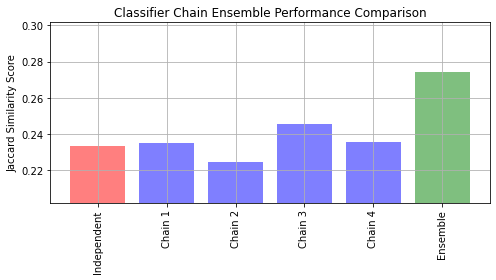

In [24]:
from sklearn.tree import DecisionTreeClassifier


# Fit an independent logistic regression model for each class using the
# OneVsRestClassifier wrapper.
base_lr = DecisionTreeClassifier()
ovr = OneVsRestClassifier(base_lr)
ovr.fit(train_features, train_labels)
Y_pred_ovr = ovr.predict(test_features)
ovr_jaccard_score = jaccard_score(test_labels, Y_pred_ovr, average="samples")

# Fit an ensemble of logistic regression classifier chains and take the
# take the average prediction of all the chains.
chains = [ClassifierChain(base_lr, order="random", random_state=i) for i in range(4)]
for chain in chains:
    chain.fit(train_features, train_labels)

Y_pred_chains = np.array([chain.predict(test_features) for chain in chains])
chain_jaccard_scores = [
    jaccard_score(test_labels, Y_pred_chain >= 0.5, average="samples")
    for Y_pred_chain in Y_pred_chains
]

Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_score(
    test_labels, Y_pred_ensemble >= 0.5, average="samples"
)

model_scores = [ovr_jaccard_score] + chain_jaccard_scores
model_scores.append(ensemble_jaccard_score)

model_names = (
    "Independent",
    "Chain 1",
    "Chain 2",
    "Chain 3",
    "Chain 4",
#    "Chain 5",
#    "Chain 6",
#    "Chain 7",
#    "Chain 8",
#    "Chain 9",
#    "Chain 10",
    "Ensemble",
)

x_pos = np.arange(len(model_names))

# Plot the Jaccard similarity scores for the independent model, each of the
# chains, and the ensemble (note that the vertical axis on this plot does
# not begin at 0).

fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title("Classifier Chain Ensemble Performance Comparison")
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation="vertical")
ax.set_ylabel("Jaccard Similarity Score")
ax.set_ylim([min(model_scores) * 0.9, max(model_scores) * 1.1])
colors = ["r"] + ["b"] * len(chain_jaccard_scores) + ["g"]
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()
